In [77]:
# install dependencies
#!pip install matplotlib
#!pip install sqlalchemy
#!pip install pandas
#!pip install scikit-learn
#!pip install prophet
#!pip install statsmodels
#!pip install hijri_converter
#!pip install xgboost
#!pip install lightgbm


## Import 

In [78]:
from pathlib import Path
import sys
import os

ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

#from sqlalchemy import create_engine
#from sqlalchemy import text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from hijri_converter import Gregorian
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import plot_importance
from decimal import Decimal
from sklearn.inspection import permutation_importance
import joblib
from scripts.features_utils import get_features_lgbm, get_features_and_dummies_lgbm, select_features_lgbm, r2_score_real, get_data

## Pull the data
Take the same aggregation level than the previous model, passengers of one route aggregated by service date.

In [79]:
# pull the data. the aggregation data is per day
data = get_data()

if data is None:
    #there was an error fetching the data. exiting
    sys.exit("Couldn't open data from database or file. Aborting.")

In [80]:
data.shape

(1186, 11)

In [81]:
# explore the data
data.head()

,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,price_mix_ratio
0,MAK-MAD,2021,53,2022-01-01,2579,12,419576.00,451077.0000,960687.672,Christmas,1.12900348972469949593
1,MAK-MAD,2022,1,2022-01-02,2038,12,343511.50,374778.0000,771785.126,Christmas,1.12644749754661432777
2,MAK-MAD,2022,1,2022-01-03,1900,12,320459.00,345114.5000,730788.374,Christmas,1.14226315789473684211
3,MAK-MAD,2022,1,2022-01-04,1810,12,306953.00,329255.0000,674187.758,Christmas,1.17303867403314917127
4,MAK-MAD,2022,1,2022-01-05,2440,14,395531.00,422114.0000,936571.790,Christmas,1.14508196721311475410


## Plot the original data

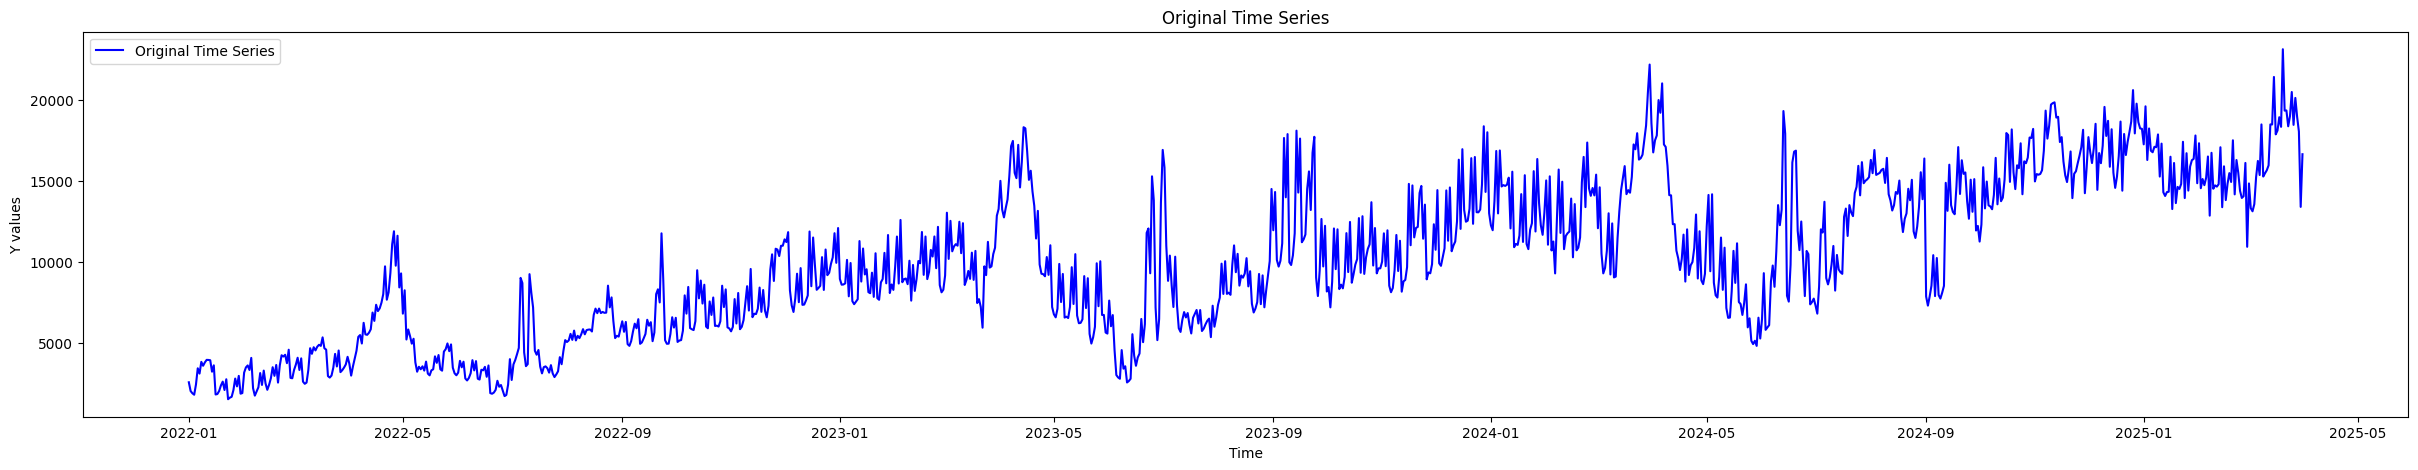

In [82]:
# load data
data.sort_values('train_departure_date_short', inplace=True)
ts_r1 = data["passengers"][data["corridor_name"]=="MAK-MAD"]
days = pd.to_datetime(data["train_departure_date_short"][data["corridor_name"]=="MAK-MAD"])

#time = np.arange(ts.shape[0])
time = range(len(ts_r1))

# Convert to DataFrame
df_r1 = pd.DataFrame({"date": days, "Y": ts_r1})
df_r1.set_index("date", inplace=True)
df_r1.sort_index(inplace=True)

# Plot the original time series
plt.figure(figsize=(30, 5))
plt.plot(df_r1["Y"], label="Original Time Series", color="blue")
plt.xlabel("Time")
plt.ylabel("Y values")
plt.title("Original Time Series")
plt.legend()
plt.show()


In [83]:
df_r1.shape

(1186, 1)

## Prepare the features
Those are all the features used at some point for the model. Not all of them were created from the beginning, many of them are created later on, at the moment at was needed. Likewise, some of those features are not used for the final model, but kept here to allow reexecution of the process, and to allow re design using them, if necessary.<br>
The function of get_features is only here for readability, but the used one is inside features_utils.<br>
Also, for the final model, there is another function just called get_features_lgbm, also inside features_utils. This second function collect the database from the original function (the one in this section), applies transformation of the number of services for the dummies variables, and return just the data frame.

In [84]:
df_r1, month_dummies, week_dummies, kind_date_dummies, weekday_dummies, hijri_dummies = get_features_and_dummies_lgbm(data)
    

#select columns
features = ['train_year',
            'lag364',
            'lag354',
            'price_ratio',
            'number_of_services'
           ] 

target = 'passengers'

index = 'train_departure_date_short'

## Get the training data
As in the previous models, the test sample is taken manually from the end of the series, in order to be able to compare with time series models.

In [85]:
def get_train_data(features, target, index):
    # filter out empty lags
    df_concat = df_r1[features+[target]+[index]].dropna()
    
    #select data
    X = df_concat[features] #.astype(float)
    y = df_concat[target].astype(float)
    y.index = df_concat[index]
    X.index = df_concat[index]
    
    # Split between training and test
    n = len(df_concat)
    train_size = int(n * 0.8)
    test_size = n - train_size
    
    return y[:train_size], y[train_size:], X[:train_size], X[train_size:], train_size, test_size

In [86]:
y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)

## Training
Perform a first training with basic features, as a first approach. The selected ones are the lag of 364 and 354. Both of them aim to capture the seasonality, because they represent the yearly frequency in gregorian and hijjri calendars, respectively. Also, those numbers have been rounded to seven to capture the weekly tendency.<br>
On the other hand we keep the year as a variable of evolution through time, and the number of services since we now positively from previous analysis that there is strong relation between the number of services and the demand captured (both because increase of frequency and because increase of available seats).<br>
In the first part of the process, three models will be trained together with the same data: XGBoosting, Random Forest, and Light GBM<br>
After working on the features, one of them will be selected as the production model.<br>

In [87]:
#XGBoosting
xgboost_parameters = {
        'objective':'reg:squarederror',
        'n_estimators':300,
        'learning_rate':0.3,
        'max_depth':0,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'random_state':42    
}
def training_models(X_train, y_train):
    # xgboost
    xgb_model = XGBRegressor(**xgboost_parameters

    )
    
    xgb_model.fit(X_train, y_train)

    # random forest regressor
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    rf.fit(X_train, y_train.astype(float))

    # light GBM regressor
    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=5,
        min_split_gain=0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    lgb_model.fit(X_train, y_train.astype(float))

    return xgb_model, rf, lgb_model

In [88]:
xgb_model, rf, lgb_model = training_models(X_train, y_train)

## Evaluation
The evaluation is done using the R2 score, the mean absolute error, and the square absolute error, even though the R2 score is used to select the final model.

In [89]:
X_test

,train_year,lag364,lag354,price_ratio,number_of_services
train_departure_date_short,,,,,
2024-10-18,3,9337.0,9606.0,0.458844,34
2024-10-19,3,12825.0,9611.0,0.495991,41
2024-10-20,3,9265.0,10019.0,0.502502,42
2024-10-21,3,10285.0,11770.0,0.505979,42
2024-10-22,3,10811.0,9742.0,0.488465,42
...,...,...,...,...,...
2025-03-27,4,18427.0,17253.0,0.966972,54
2025-03-28,4,20435.0,17100.0,0.981182,53
2025-03-29,4,22184.0,15937.0,0.980753,52


In [90]:
def evaluation(X_test, y_test, adjust_prices=False, prices=None, elasticity=None):
    # forecasting
    y_pred_xgboost = xgb_model.predict(X_test)
    y_pred_rf = rf.predict(X_test)
    y_pred_lgb = lgb_model.predict(X_test)
    
    
    # evaluation XGBOOST
    print("\nEvaluating XGBOOST")
    print("R² Score:", r2_score(y_test, y_pred_xgboost))
    if adjust_prices:
        print("R² Score after price adjustment:", r2_score_real(y_test, y_pred_xgboost, prices, elasticity))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_xgboost))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred_xgboost))
    
    # evaluation random forest regressor
    print("\nEvaluating random forest regressor")
    print("R² Score:", r2_score(y_test, y_pred_rf))
    if adjust_prices:
        print("R² Score after price adjustment:", r2_score_real(y_test, y_pred_rf, prices, elasticity))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rf))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
    
    # evaluation light GBM regressor
    print("\nEvaluating light GBM regressor")
    print("R² Score:", r2_score(y_test, y_pred_lgb)) 
    if adjust_prices:
        print("R² Score after price adjustment:", r2_score_real(y_test, y_pred_lgb, prices, elasticity))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_lgb))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lgb))

    return y_pred_xgboost, y_pred_rf, y_pred_lgb

y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: -0.6597707009841756
Mean Absolute Error: 1987.2386245265152
Mean Squared Error: 6213372.147007589

Evaluating random forest regressor
R² Score: -0.025098980465386278
Mean Absolute Error: 1608.661298688386
Mean Squared Error: 3837470.711690936

Evaluating light GBM regressor
R² Score: -0.054234892522588396
Mean Absolute Error: 1605.826976515943
Mean Squared Error: 3946541.358827036


## Plot Result

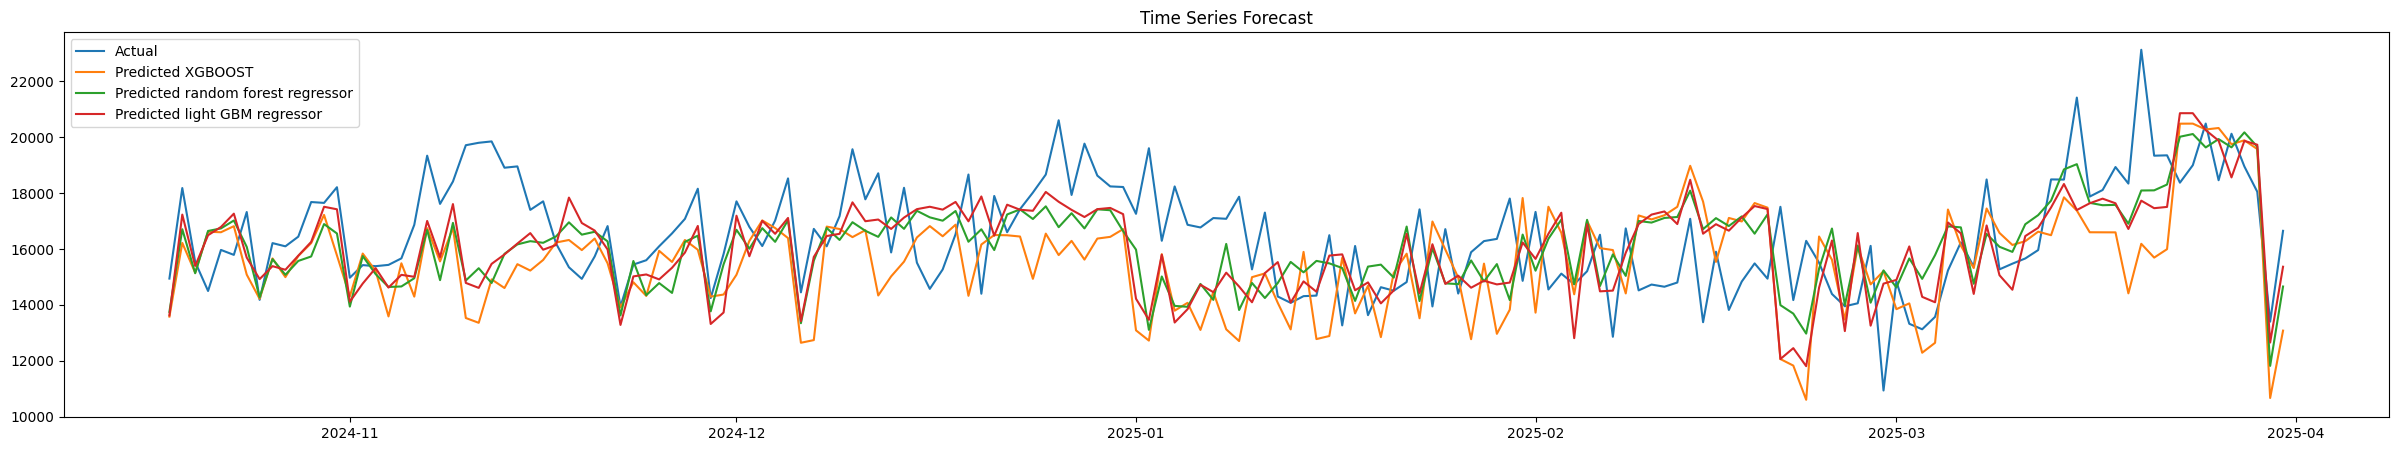

In [91]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()


## Standarization of Prices
As happened in previous models, some of the periods where the predictions fall shorter are precisely when the promotions were applied in the previous year. So, the conclusion is that the model is not capturing the effect of the price on the demand as precise as before. As a test to compare, let's see the difference when using the elasticity correction used in the previous model.

In [92]:
# check the elasticity
import statsmodels.api as sm

#parameters (log-log)
y_occ = np.log(df_r1['passengers'].astype(float))
X_prices = np.log((df_r1['revenue'] / df_r1['revenue_without_promotion']).astype(float))
X_prices = sm.add_constant(X_prices)

# linear modelling
result_prices = sm.OLS(y_occ, X_prices).fit()
print(result_prices.summary()) 

elasticity = Decimal(-.7661) #actually same as before, since it is the same data 

                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     87.12
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.88e-20
Time:                        07:06:53   Log-Likelihood:                -960.56
No. Observations:                1186   AIC:                             1925.
Df Residuals:                    1184   BIC:                             1935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9860      0.019    476.923      0.0

In [93]:
# adjust the passengers according to the prices 
df_r1['adjusted_passengers'] = df_r1['passengers'].astype(float) * ( 1 / df_r1['price_ratio'] ** float(elasticity))
#y_adj_train = y_train * ( 1 / X_train['price_ratio'] ** elasticity)
#y_adj_test = y_test * ( 1 / X_test['price_ratio'] ** elasticity)
#X_adj_train = X_train.drop(labels=['price_ratio'], axis=1)
#X_adj_test = X_test.drop(labels=['price_ratio'], axis=1)

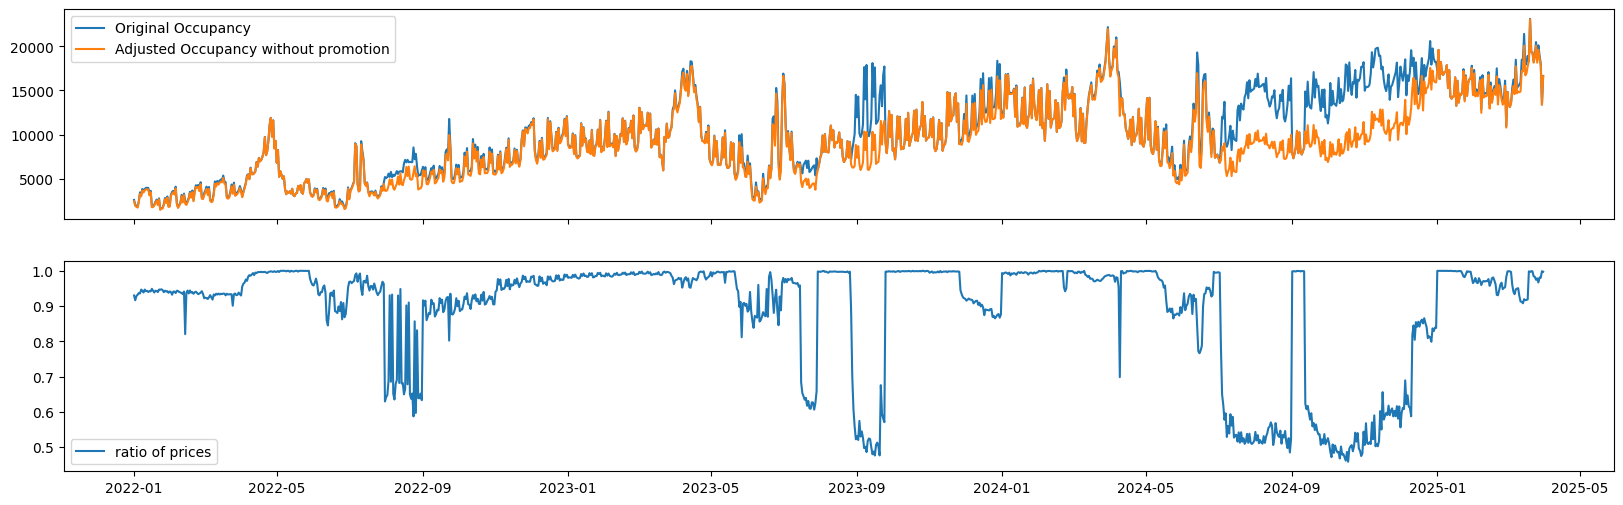

In [94]:
# check visually the adjustment done
fig, axs = plt.subplots(2, sharex=True, figsize=(20, 6))
axs[0].plot(df_r1['passengers'], label="Original Occupancy")
axs[0].plot(df_r1['adjusted_passengers'], label="Adjusted Occupancy without promotion")
axs[0].legend()

# check visually the correctness of ratio
#ratio_indexed = df_r1['price_ratio']
#ratio_indexed.index = df_r1['train_departure_date_short']
axs[1].plot(df_r1['price_ratio'], label="ratio of prices")
axs[1].legend()
plt.show()


## Training with the prices adjusted
This time the models will be trained using the adjusted amount of passengers done in the previous step. That target measure the amount of passengers we could get without modifications of price.<br>
The final target is the real passengers, and the adjustment is only made to check how good would be the model in case there was no interference of prices.<br>
At the end, either we create a composite model reverting the adjustment made here to get the real passengers, or we let the machine learning models get the relation between the prices and the amount of passengers. Since these models are capable of non linear relations between the variables, the later seems more likely. Anyhow, the first approach will be tested as well.<br>

In [95]:
df_r1['price_ratio'].shape[0]
test_size

165

In [96]:
target_adj = 'adjusted_passengers'
y_adj_train, y_adj_test, X_adj_train, X_adj_test, train_size, test_size = get_train_data(features, target_adj, index)
xgb_model, rf, lgb_model = training_models(X_adj_train, y_adj_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_adj_test, y_adj_test, adjust_prices=True, prices=df_r1['price_ratio'][-test_size:], elasticity=float(elasticity))


Evaluating XGBOOST
R² Score: 0.47609162673696914
R² Score after price adjustment: -0.7215832594946863
Mean Absolute Error: 1762.6685000822365
Mean Squared Error: 4530563.39688334

Evaluating random forest regressor
R² Score: 0.3860881688182016
R² Score after price adjustment: -1.503899783606224
Mean Absolute Error: 1945.766408704102
Mean Squared Error: 5308879.592709774

Evaluating light GBM regressor
R² Score: 0.5660434299566975
R² Score after price adjustment: -0.36333006804311974
Mean Absolute Error: 1577.7741562983433
Mean Squared Error: 3752693.891548385


In [97]:
X_adj_train.describe()


,train_year,lag364,lag354,price_ratio,number_of_services
count,657.000000,657.000000,657.000000,657.000000,657.000000
mean,2.442922,7215.117199,7336.747336,0.880420,34.001522
std,0.500167,3470.706350,3459.443199,0.179337,7.233792
min,1.000000,1533.000000,1533.000000,0.462009,16.000000
25%,2.000000,4415.000000,4571.000000,0.875135,28.000000
50%,2.000000,6886.000000,7115.000000,0.982152,34.000000
75%,3.000000,9296.000000,9388.000000,0.996694,38.000000
max,3.000000,18317.000000,18317.000000,1.000000,60.000000


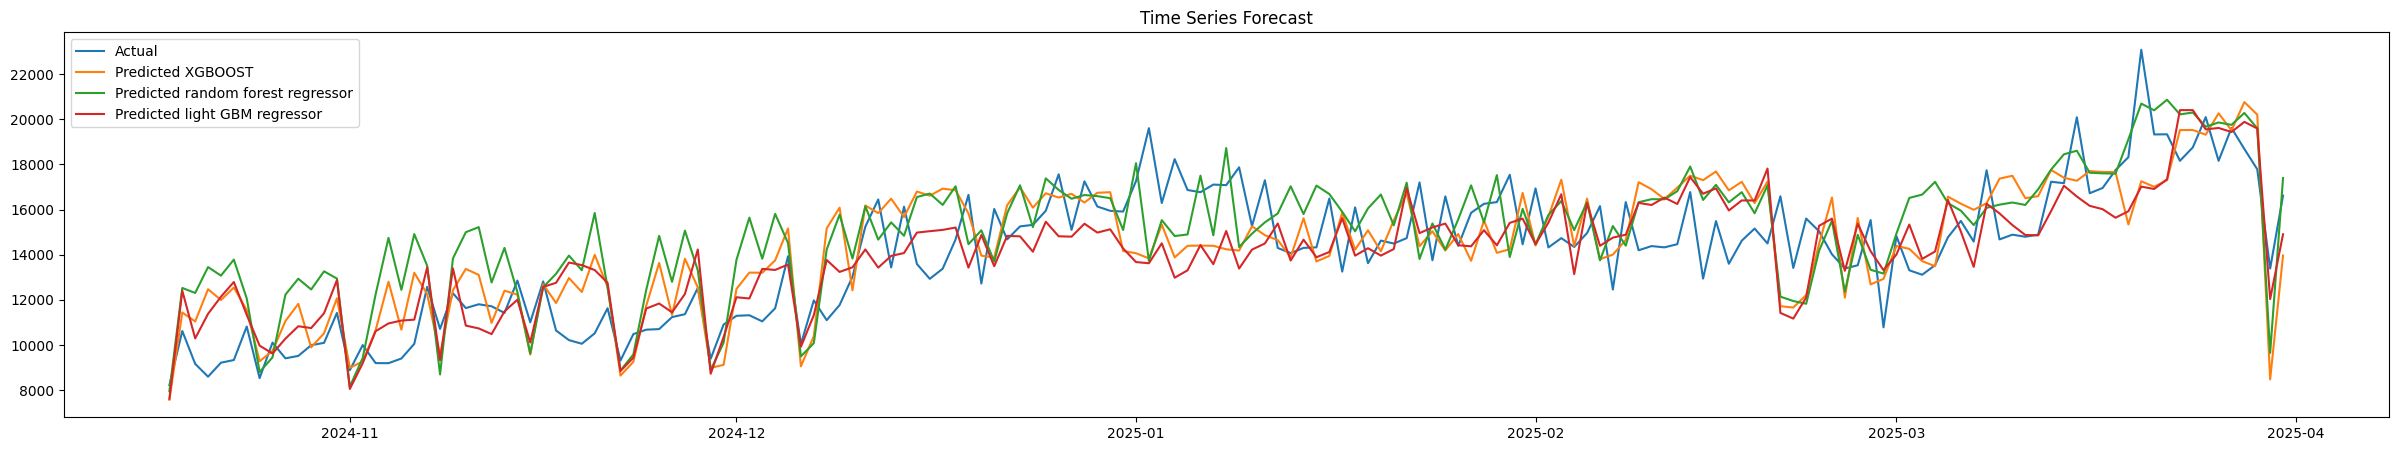

In [98]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_adj_test, label='Actual')
plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()


## Analyzing the outcome
From the previous step, we assert that not only the information of the prices is missing, since even targeting the adjusted passenger the final score is low.<br>
It is clear that, besides the prices, more features are needed.<br>

In [99]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

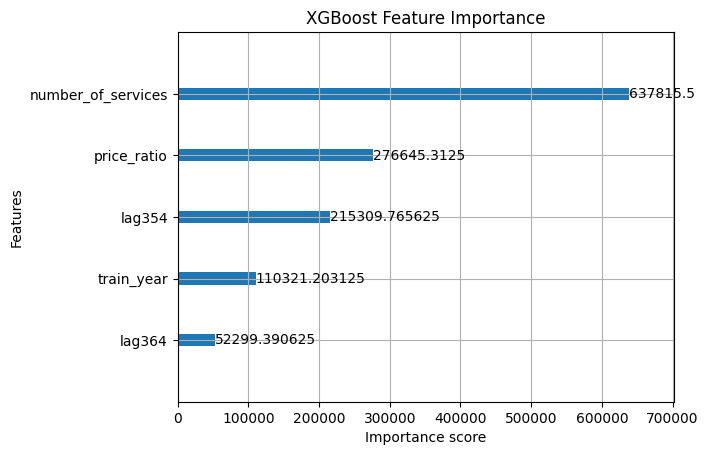

In [100]:
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()



## Turn to Dummies
Probably, the idea of using the lags 354 and 364 as a representation of the seasonality (both weekly and yearly) it did not work. So let compare with the features used during the linear regression. The difference in performance is so high, so the lags selected were distorting the result.

In [101]:
#select different columns
features = [
            #'train_year',
            #'lag364',
            #'lag354',
            'price_ratio',
            'number_of_services'
           ]    + weekday_dummies.columns.tolist() +kind_date_dummies.columns.tolist() + week_dummies.columns.tolist() + hijri_dummies.columns.tolist()  #+ month_dummies.columns.tolist()

y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)
xgb_model, rf, lgb_model = training_models(X_train, y_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: 0.06619183640601756
Mean Absolute Error: 2011.6613256630778
Mean Squared Error: 6245823.838651236

Evaluating random forest regressor
R² Score: 0.4824416714083162
Mean Absolute Error: 1462.62136117299
Mean Squared Error: 3461715.4493157184

Evaluating light GBM regressor
R² Score: 0.4501717602729194
Mean Absolute Error: 1486.955354854706
Mean Squared Error: 3677554.406500347


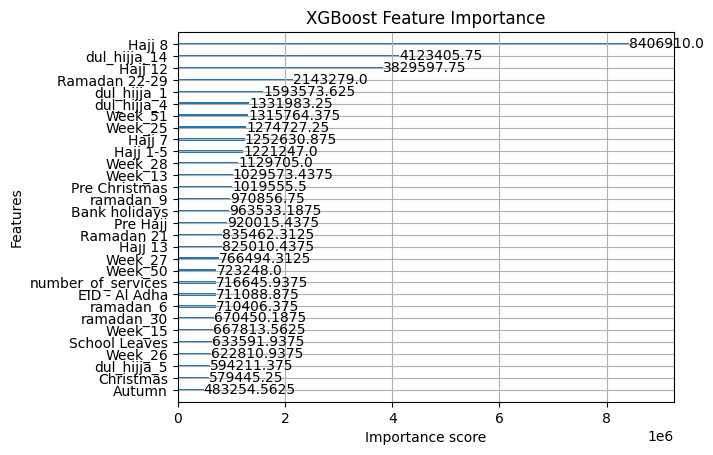

In [102]:
plot_importance(xgb_model, importance_type='gain', max_num_features=30)
plt.title("XGBoost Feature Importance")
plt.show()

In [103]:
y_test

train_departure_date_short
2024-08-06    15501.0
2024-08-07    15685.0
2024-08-08    15750.0
2024-08-09    14879.0
2024-08-10    16425.0
               ...   
2025-03-27    20125.0
2025-03-28    18955.0
2025-03-29    18050.0
2025-03-30    13401.0
2025-03-31    16651.0
Name: passengers, Length: 238, dtype: float64

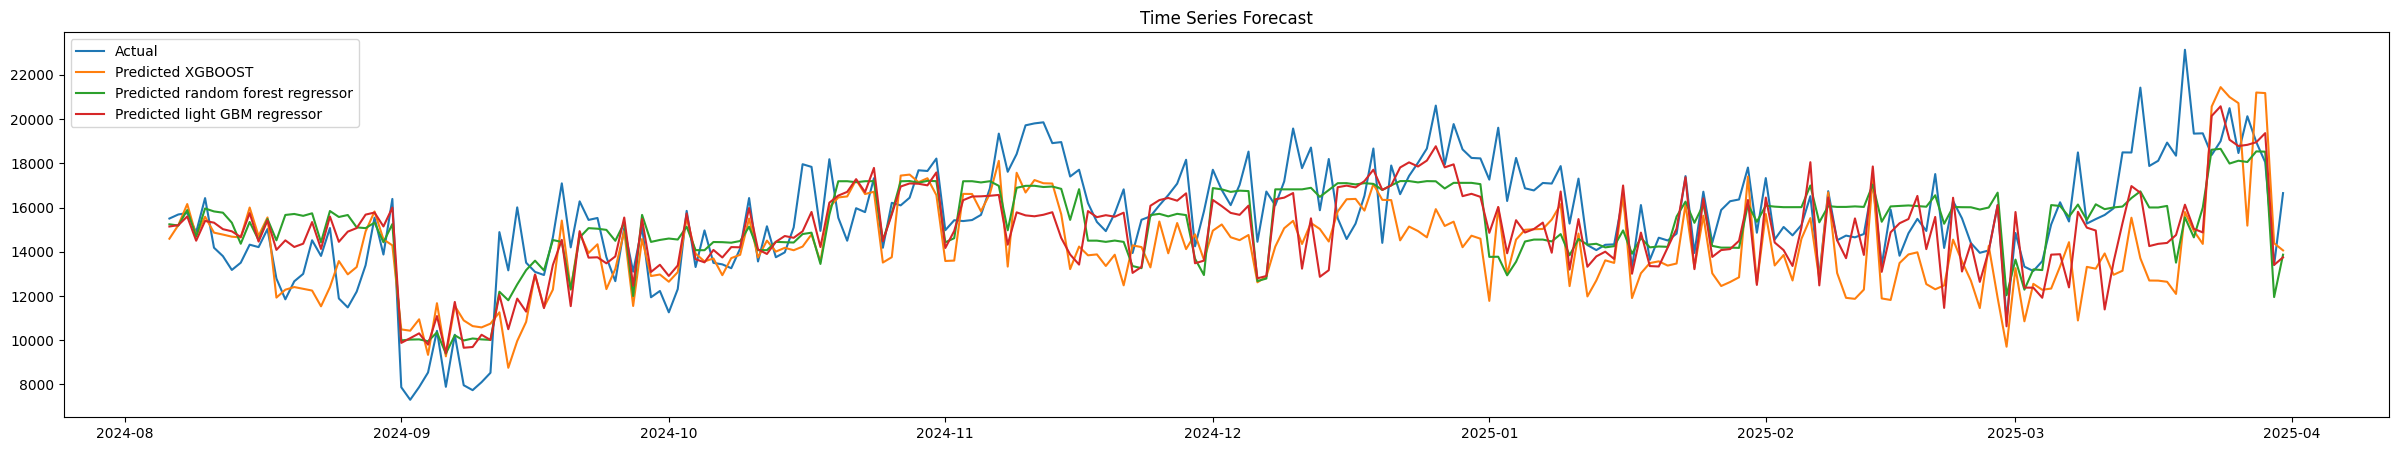

In [104]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()


## Number of services
The number of services has a key role in the previous models, which matematically matches, but theoretically is overrated: The service can attract new customers (An increase of the number of services means a slight reduction of average prices due to dynamic price system, plus increase of train frequency that can attract customers), but it is not the key reason that explain the number of customers. This idea can be seen in the fact that the forecast became so sensible to modifications of the level of services (with the consequent error when the level of services differ from the ideal). In order to make the model more flexible to different scenarios, that parameters should have less importance.<br>
In order to shift some weight to the other variables, a combination of both will be made: the dummy variables will hold the information of the number of services, instead of just 0 and 1. That way, different periods or days of the week will have different "coefficient" for the same number of services. This approach try to capture the different demand in such periods, at the same time that we use the information that the number of services provide to the model.<br>

In [105]:
# group the number of services by week
df_r1['week_key'] = list(zip(df_r1['train_year'], df_r1['train_week_num']))
df_weekly_services = df_r1.groupby('week_key')['number_of_services'].sum().rename('weekly_services')
df_r1 = df_r1.merge(df_weekly_services, left_on='week_key', right_index=True)

#drop the incomplete weeks
week_counts = df_r1['week_key'].value_counts()
valid_weeks = valid_weeks = week_counts[week_counts == 7].index
df_r1 = df_r1[df_r1['week_key'].isin(valid_weeks)]

In [106]:
# accumulate the level of service with the day of the week
df_r1[weekday_dummies.columns.tolist()] = df_r1[weekday_dummies.columns.tolist()].values * df_r1['number_of_services'].values.reshape(-1,1)

In [107]:
# accumulate the lvel of service with the period of the year
df_r1[kind_date_dummies.columns.tolist()] = df_r1[kind_date_dummies.columns.tolist()].values * df_r1['number_of_services'].values.reshape(-1,1) 

In [108]:
df_r1[week_dummies.columns.tolist()] = df_r1[week_dummies.columns.tolist()].values  * df_r1['number_of_services'].values.reshape(-1,1) 

In [109]:
df_r1[hijri_dummies.columns.tolist()] = df_r1[hijri_dummies.columns.tolist()].values  * df_r1['number_of_services'].values.reshape(-1,1) 

In [110]:
# use the new column instead the daily services
features = [
            'train_year',
            #'lag364',
            #'lag354',
            'price_ratio',
            'number_of_services'
           ]    + weekday_dummies.columns.tolist() +kind_date_dummies.columns.tolist() + week_dummies.columns.tolist() #+ hijri_dummies.columns.tolist()    #+ month_dummies.columns.tolist()

y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)
xgb_model, rf, lgb_model = training_models(X_train, y_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: 0.4074731347927202
Mean Absolute Error: 1610.7561354496308
Mean Squared Error: 3965385.608968288

Evaluating random forest regressor
R² Score: 0.506545213754361
Mean Absolute Error: 1396.4469832364978
Mean Squared Error: 3302362.513757864

Evaluating light GBM regressor
R² Score: 0.5755901392517178
Mean Absolute Error: 1338.87939798518
Mean Squared Error: 2840291.053346144


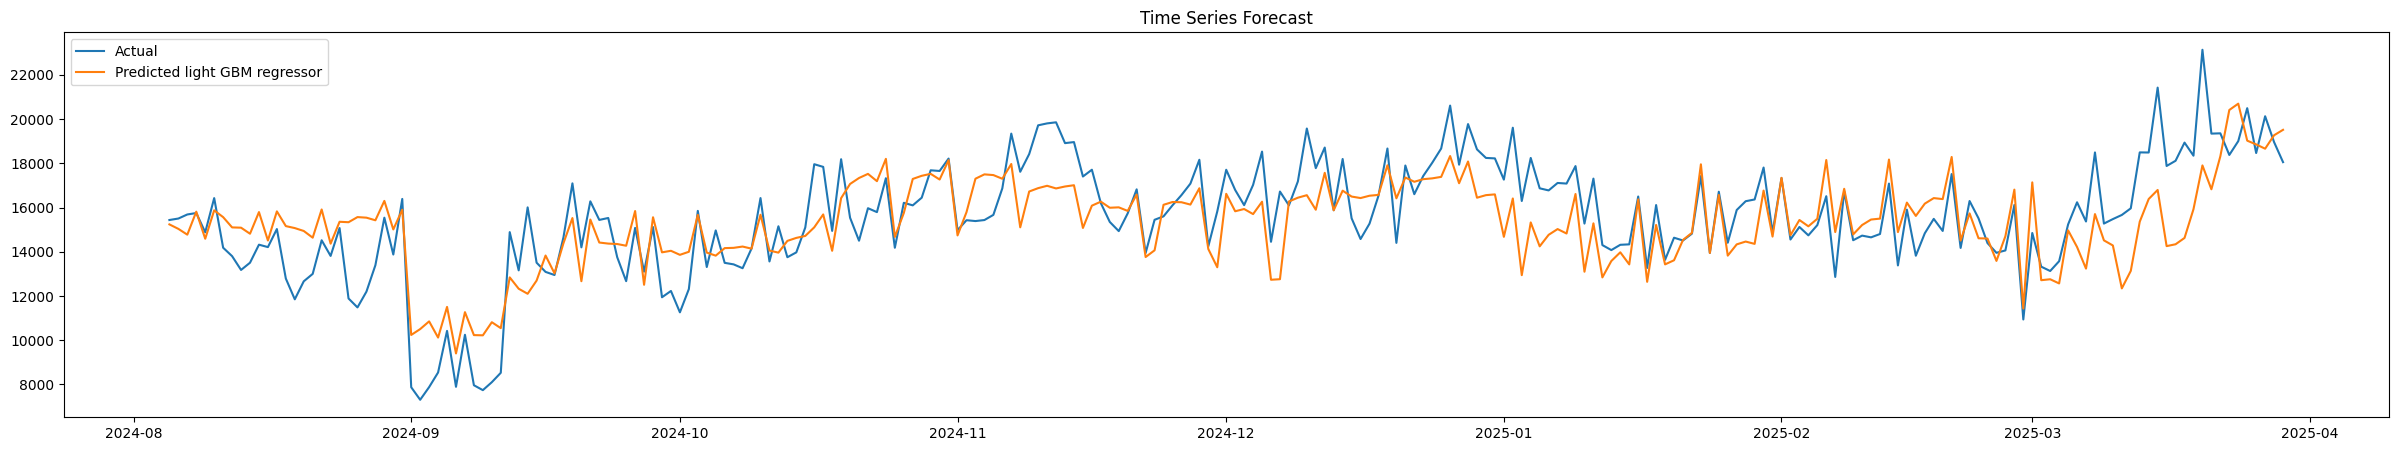

In [111]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
#plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()

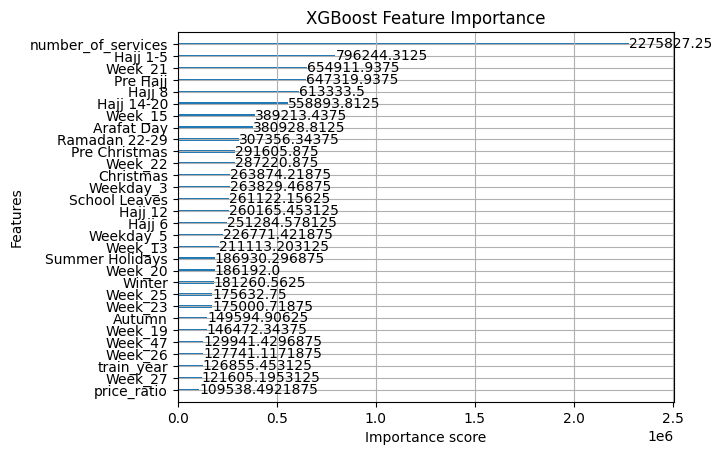

In [112]:
plot_importance(xgb_model, importance_type='gain', max_num_features=30)
plt.title("XGBoost Feature Importance")
plt.show()

Even though there is a succeess in reduction the weight of the variable for the number of services, it is still the most important.<br>
The results has improved slightly, too.<br>

## Price Mix
Aside of reduction of price, the pricing is a dynamic system based on occupation. The default Price Mix is 50% minimum price, 30% intermedium price, 20% maximum price, but those paramters can change per each service due to a different factors, such system inaccuracy, misplacement of quotas (changing the available seats and thus forcing change of price), or just pricing strategy. A price mix ratio will be calculated as a parameter independent of price ratio, to be trained by the model.

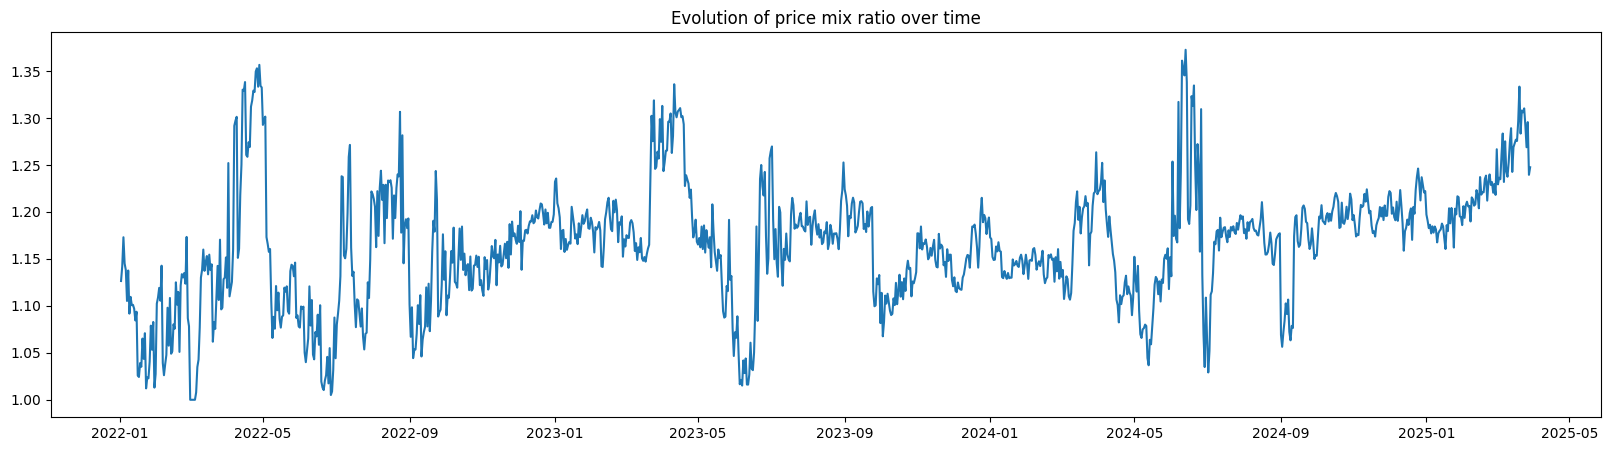

In [113]:
plt.figure(figsize=(20,5))
plt.plot(df_r1['price_mix_ratio'], label='Price Mix Ratio')
plt.title('Evolution of price mix ratio over time')
#plt.legend()
plt.show()

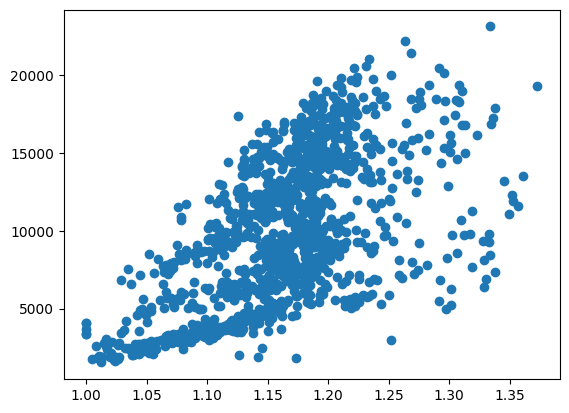

In [114]:
plt.scatter(df_r1['price_mix_ratio'], df_r1['passengers'])

In [115]:
# created the new ratio in the query, add it to the features
features = [
            'train_year',
            #'lag364',
            #'lag354',
            'price_ratio',
            'number_of_services',
            'price_mix_ratio'
           ]    + weekday_dummies.columns.tolist() +kind_date_dummies.columns.tolist() + month_dummies.columns.tolist() #+ week_dummies.columns.tolist()  #+ hijri_dummies.columns.tolist() # 

y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)
xgb_model, rf, lgb_model = training_models(X_train, y_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: 0.30944138531309306
Mean Absolute Error: 1674.547282931171
Mean Squared Error: 4621446.475461674

Evaluating random forest regressor
R² Score: 0.585526384793617
Mean Absolute Error: 1329.3032475684147
Mean Squared Error: 2773794.414303053

Evaluating light GBM regressor
R² Score: 0.7104440103529388
Mean Absolute Error: 1110.4984943718075
Mean Squared Error: 1937804.3794442292


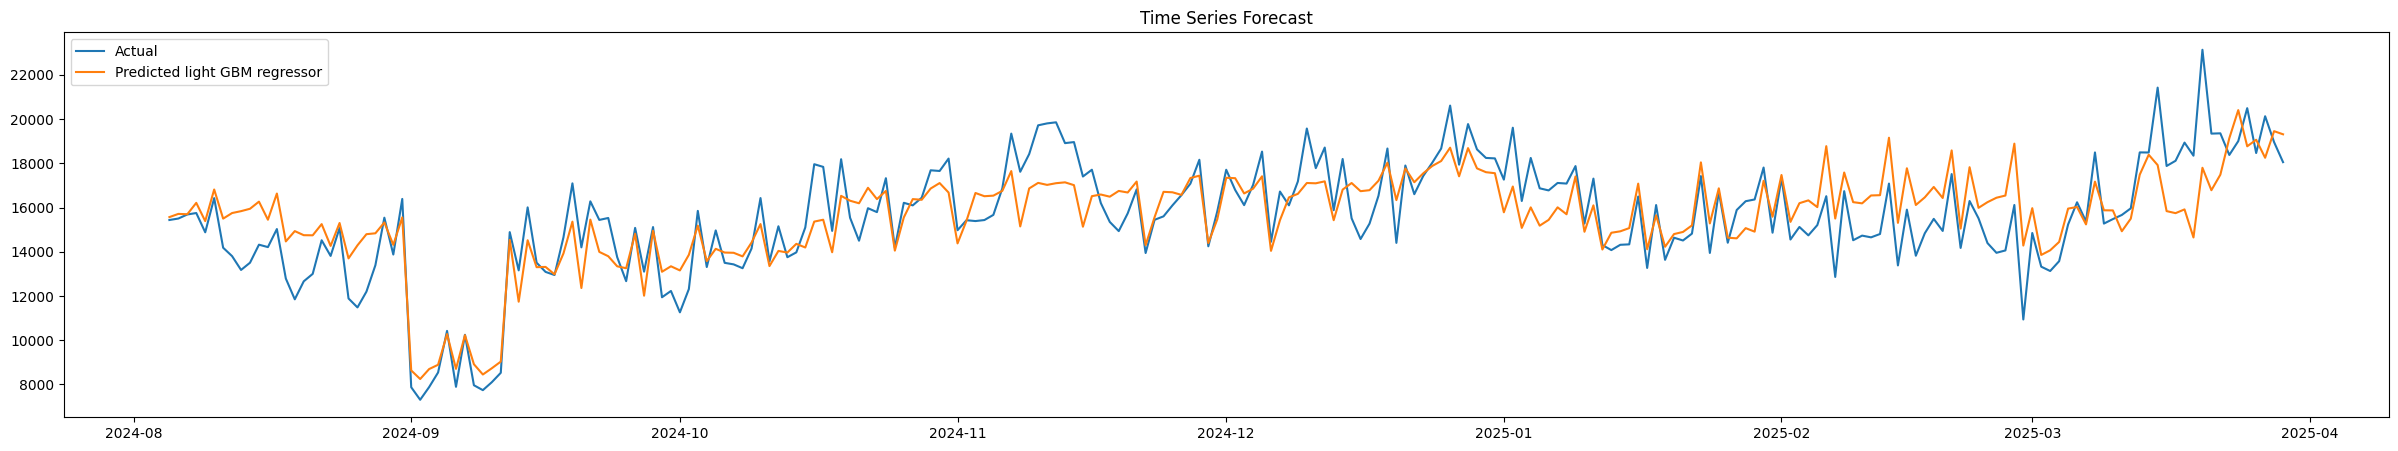

In [116]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
#plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()

In [117]:
kind_date_dummies.columns

Index(['Arafat Day', 'Autumn', 'Bank holidays', 'Christmas', 'EID - Al Adha',
       'EID - Ramadan', 'Foundation Day', 'Hajj 1-5', 'Hajj 12', 'Hajj 13',
       'Hajj 14-20', 'Hajj 6', 'Hajj 7', 'Hajj 8', 'Pre Christmas', 'Pre Hajj',
       'Pre Ramadan', 'Ramadan 1-18', 'Ramadan 19', 'Ramadan 20', 'Ramadan 21',
       'Ramadan 22-29', 'School Leaves', 'Summer Holidays', 'Winter'],
      dtype='object')

## Smoothing
Three new features will be tested to try to simplify the model while capturing the maximum amount of information possible.<br>
Some near information of previous data can help model it as a way to adjust the forescast according to the nearest information available.<br>
After some testing, from the three features tested (lag7, lag14, rolling6), only one of them is kept to the final model (rolling6). The other two were not giving improvement in the results.<br>

In [118]:
df_r1['rolling6'] = df_r1['passengers'].astype(float).rolling(6).mean()
df_r1['lag7'] = df_r1['passengers'].shift(7)
df_r1['lag14'] = df_r1['passengers'].shift(14)

In [119]:
# add the new features
features = [
            'train_year',
            #'lag364',
            #'lag354',
            'price_ratio',
            'number_of_services',
            'price_mix_ratio',
            'rolling6',
            #'lag7',
            #'lag14'
           ]   + weekday_dummies.columns.tolist() +kind_date_dummies.columns.tolist() + month_dummies.columns.tolist() #+ week_dummies.columns.tolist() #+ hijri_dummies.columns.tolist() # 

y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)
xgb_model, rf, lgb_model = training_models(X_train, y_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: 0.600365654392017
Mean Absolute Error: 1308.6161467988613
Mean Squared Error: 2685799.3485057787

Evaluating random forest regressor
R² Score: 0.6694757860445562
Mean Absolute Error: 1179.2327205528045
Mean Squared Error: 2221334.898421661

Evaluating light GBM regressor
R² Score: 0.7476067083516929
Mean Absolute Error: 1034.282326186535
Mean Squared Error: 1696244.9442251122


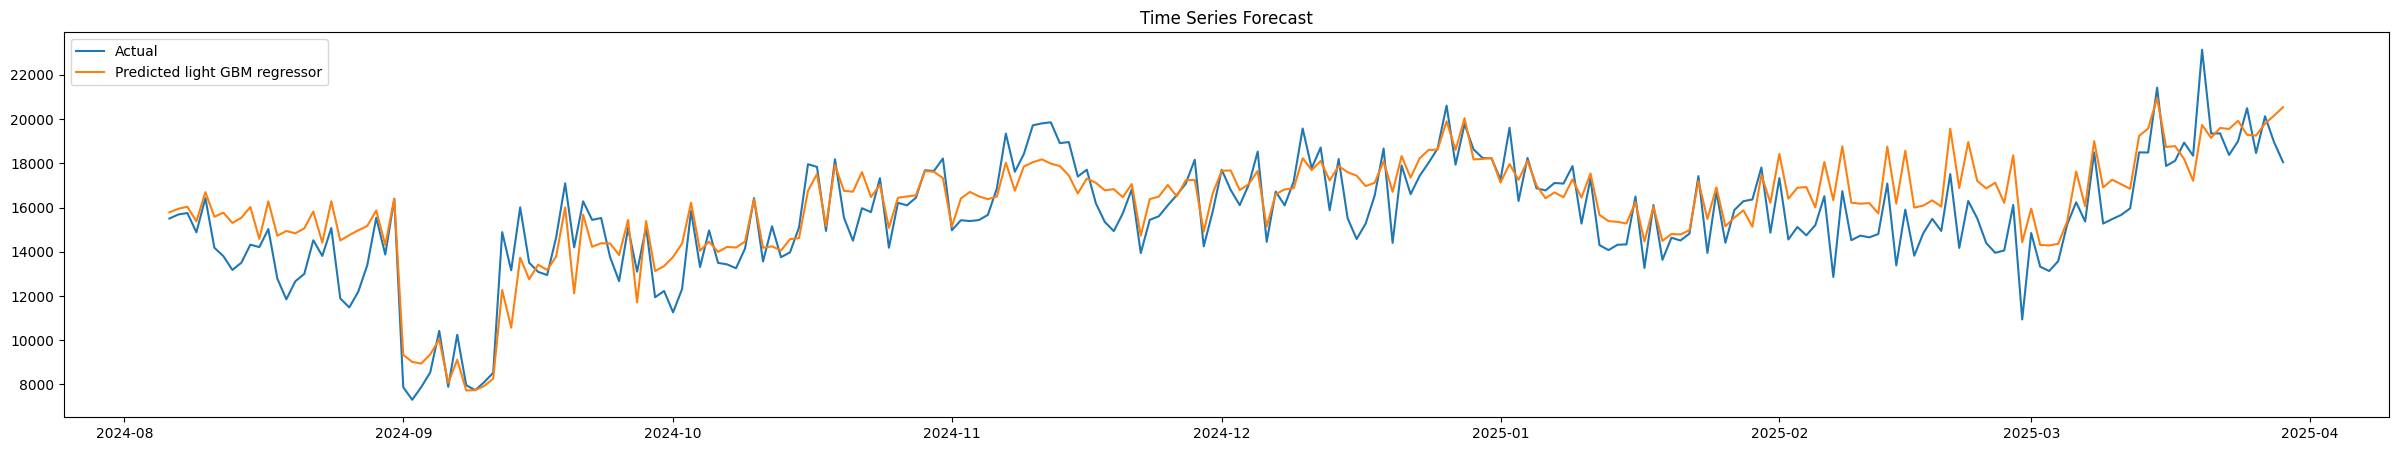

In [120]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, y_pred_xgboost, label='Predicted XGBOOST')
#plt.plot(y_test.index, y_pred_rf, label='Predicted random forest regressor')
plt.plot(y_test.index, y_pred_lgb, label='Predicted light GBM regressor')
plt.legend()
plt.title("Time Series Forecast")
plt.show()

## Drop Features
We try to remove each one of the features and see the imapct in the outcome.<br>
Interestingly, the number of services can be removed now, since this information is appearing already in the dummies. This not only improve the inmediate performance in the current tests, but give consistency to the model for the future.<br> 

In [121]:
# redundant features
# created the new ratio in the query, add it to the features
features = [
            'train_year',
            #'lag364',
            #'lag354',
            'price_ratio',
            #'number_of_services',
            'price_mix_ratio',
            'rolling6',
            #'lag7',
            #'lag14'
           ]    + weekday_dummies.columns.tolist() +kind_date_dummies.columns.tolist()  #+ week_dummies.columns.tolist()  # + month_dummies.columns.tolist()+ hijri_dummies.columns.tolist() # 

y_train, y_test, X_train, X_test, train_size, test_size = get_train_data(features, target, index)
xgb_model, rf, lgb_model = training_models(X_train, y_train)
y_pred_xgboost, y_pred_rf, y_pred_lgb = evaluation(X_test, y_test)


Evaluating XGBOOST
R² Score: 0.6797656752785493
Mean Absolute Error: 1141.630960755429
Mean Squared Error: 2152180.237155471

Evaluating random forest regressor
R² Score: 0.766480734824968
Mean Absolute Error: 1000.2755396890623
Mean Squared Error: 1569399.370107894

Evaluating light GBM regressor
R² Score: 0.7646776551709665
Mean Absolute Error: 994.2829558233844
Mean Squared Error: 1581517.2228731606


<Axes: >

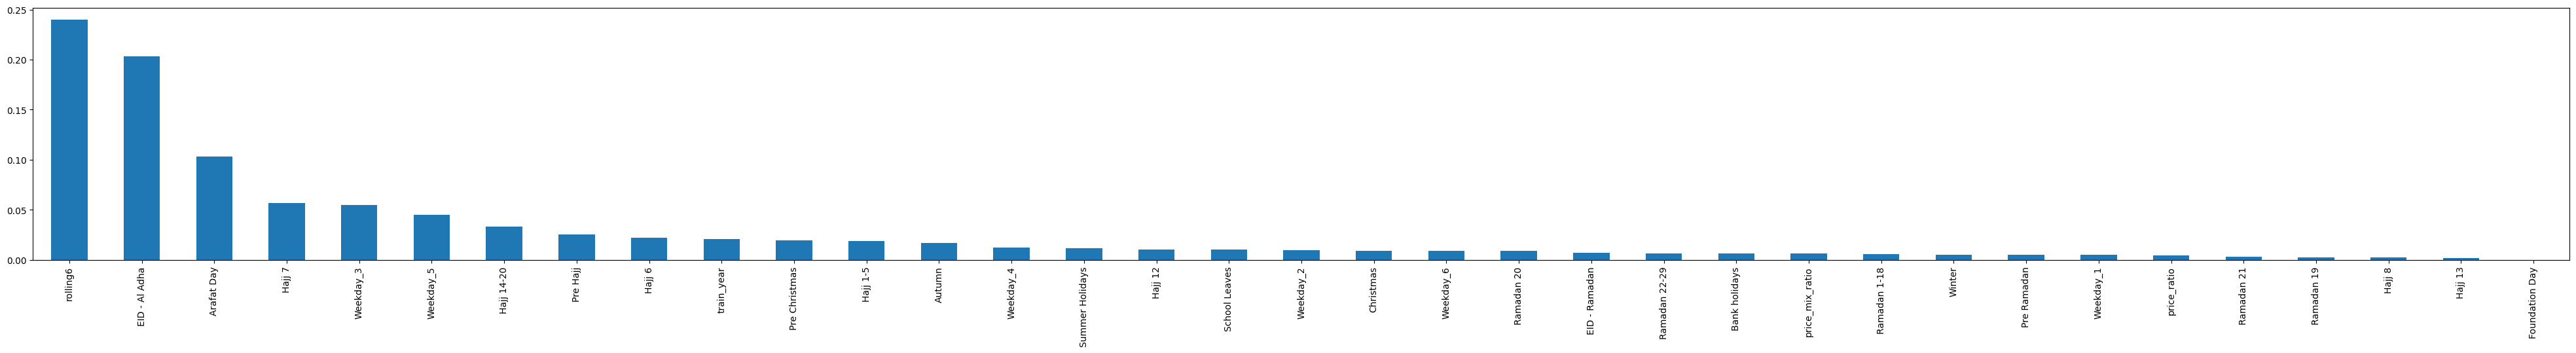

In [122]:
feat_imp = pd.Series(xgb_model.feature_importances_, index=features)
feat_imp.sort_values(ascending=False).plot(kind='bar', figsize=(50,5))


## Parameter Fine Tuning
The final outcome, even if it is not excellent, is fine. There is, anyway, overfitting, so the parameters of the model can be improved in order to create a more generalized model that can work in different situations.<br>
At this point, only the best performance model will be choosen.<br>

In [123]:
def check_overfitting(model, y_train, y_test, X_train, X_test):
    # check the level of overfitting
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    
    print("R² Train:", r2_train)
    print("R² Test :", r2_test)
    print("RMSE Train:", rmse_train)
    print("RMSE Test :", rmse_test)

check_overfitting(lgb_model, y_train, y_test, X_train, X_test)

R² Train: 0.9994864485932272
R² Test : 0.7646776551709665
RMSE Train: 92.12045979322139
RMSE Test : 1257.5838830364996


In [124]:
# 
lgbm_params = {
    "objective": "regression_l2",        # best fit regression_l2
    "metric": "rmse",                 # rmse
    #"learning_rate": 0.1,
    "num_leaves": 3, # reduced to 3
    #"max_depth": 3,                  
    "min_data_in_leaf": 10, 
    "feature_fraction": 1, #changed to 1
    "bagging_fraction": 1, #idem
    #"bagging_freq": 20,
    #"lambda_l1": 0.8,
    "lambda_l2": 0.8,
    "verbosity": -1,
    "boosting": "gbdt",                # gbdt
    "n_estimators": 100, #down to 100
    #"subsample":0.8,
    #"colsample_bytree":0.8,
    "random_state":42
}

lgbm_model_tuning = lgb.LGBMRegressor(**lgbm_params)
lgbm_model_tuning.fit(X_train, y_train, eval_set=[(X_test, y_test)])
check_overfitting(lgbm_model_tuning, y_train, y_test, X_train, X_test)

R² Train: 0.9407844782654717
R² Test : 0.8135230899131635
RMSE Train: 989.1950065898533
RMSE Test : 1119.484053029276


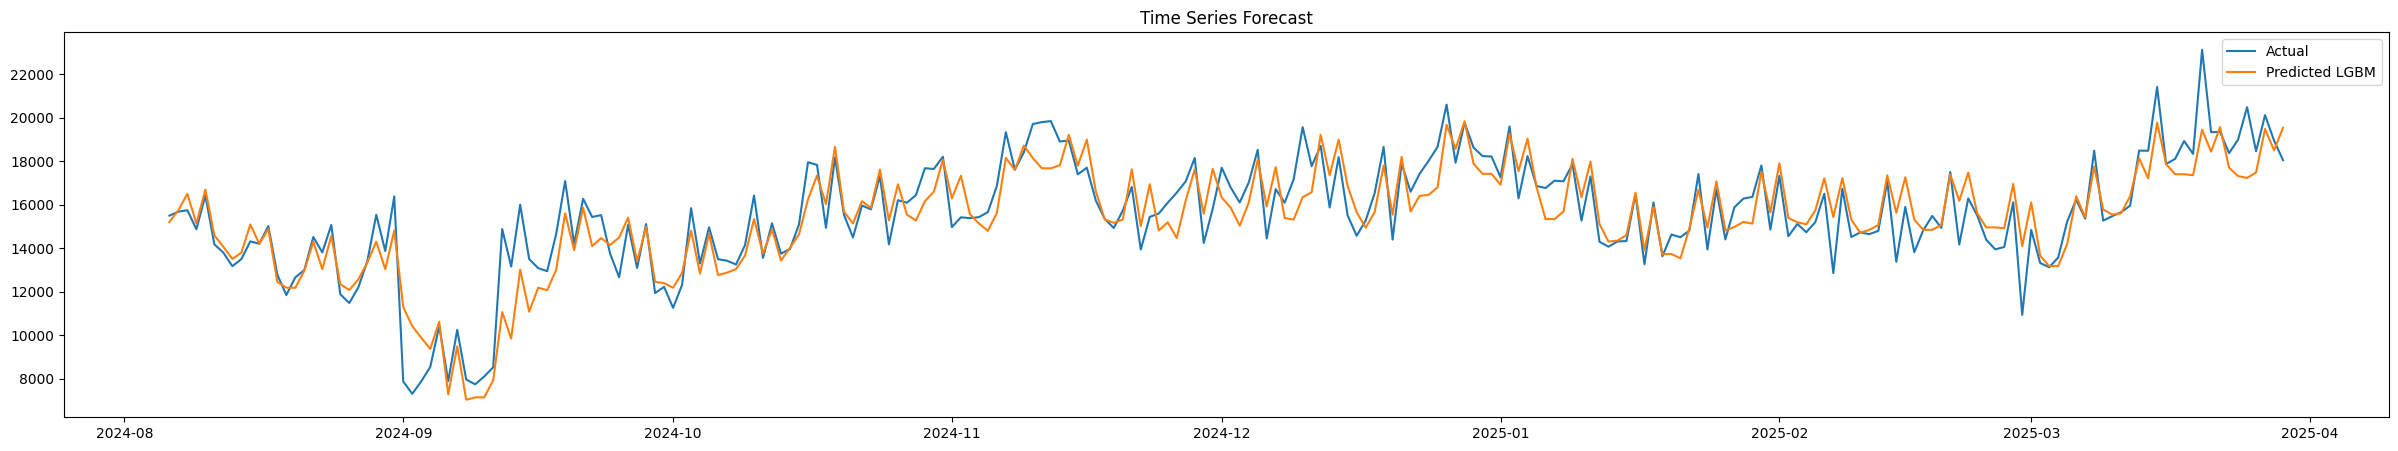

In [125]:
plt.figure(figsize=(30,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, lgbm_model_tuning.predict(X_test), label='Predicted LGBM')
plt.legend()
plt.title("Time Series Forecast")
plt.show()

Thanks to the fine tunning, we reduce the overfitting, since the difference between the scores for training and test has reduced from around 0.24 to around 0.13, at the same time that the result for the test set has improved from 0.76 to 0.81.

## Export
The model will use in the visual representation alognside the other methods.<br>
For this model a pipeline is exported, along with the information of the features selected, in order to be used outside this notebook.<br>

In [126]:
#save the features to be used by the select_features function
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

with open(os.path.join(ROOT_DIR, "features", "features_lgbm.json"), "w") as f:
    json.dump(features, f)
    
# create a pipeline with the model and the feature engineering
pipeline = Pipeline([
    ('features', FunctionTransformer(get_features_lgbm, validate=False)),
    ('filter', FunctionTransformer(select_features_lgbm, validate=False)),
    ('model', lgbm_model_tuning)
])

# save the pipeline
joblib.dump(pipeline, os.path.join(ROOT_DIR, "models", "pipeline_lgbm.pkl"))


['C:\\Users\\Joan\\Documents\\jpnb\\models\\pipeline_lgbm.pkl']